In [28]:
!pip -q install einops tslearn torchmetrics tqdm scikit-learn

In [ ]:
import math, random, os, time
from dataclasses import dataclass
from typing import Tuple, Dict, Optional, List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

@dataclass
class UticaConfig:
    # time / patches
    T_base: int = 512
    T_global: int = 512
    T_local: int = 256
    n_patches: int = 32  

    # model (paper backbone: L=6, D=256, H=8, MLP=512)
    d_model: int = 256
    n_layers: int = 6
    n_heads: int = 8
    mlp_dim: int = 512
    dropout: float = 0.0

    # heads 
    head_hidden: int = 2048
    head_bottleneck: int = 256
    prototypes_k: int = 1024 

    # crops 
    n_global: int = 2
    n_local: int = 8
    global_remove: Tuple[float,float] = (0.0, 0.6)
    local_remove: Tuple[float,float]  = (0.6, 0.9)
    jitter_sigma: float = 0.2
    jitter_p: float = 0.5

    # masking 
    mask_ratio: Tuple[float,float] = (0.1, 0.7)


    # teacher schedules 
    m_start: float = 0.992
    m_end: float = 1.0
    t_start: float = 0.04
    t_end: float = 0.04
    temp_warmup_epochs: float = 1.5

    # optimization defaults
    lr: float = 5e-4
    min_lr: float = 5e-7
    wd_start: float = 0.04
    wd_end: float = 0.4
    clip_grad: float = 3.0
    warmup_epochs: float = 0.5

    # DINO temperatures
    student_temp: float = 0.2        # typical DINO value
    teacher_temp_start: float = 0.04 # start of schedule
    teacher_temp_end: float = 0.07   # end of schedule
    teacher_temp_warmup_epochs: float = 1.5

cfg = UticaConfig()
print(cfg)

UticaConfig(T_base=512, T_global=512, T_local=256, n_patches=32, d_model=256, n_layers=6, n_heads=8, mlp_dim=512, dropout=0.0, head_hidden=2048, head_bottleneck=256, prototypes_k=1024, n_global=2, n_local=8, global_remove=(0.0, 0.6), local_remove=(0.6, 0.9), jitter_sigma=0.2, jitter_p=0.5, mask_ratio=(0.1, 0.7), m_start=0.992, m_end=1.0, t_start=0.04, t_end=0.04, temp_warmup_epochs=1.5, lr=0.0005, min_lr=5e-07, wd_start=0.04, wd_end=0.4, clip_grad=3.0, warmup_epochs=0.5, student_temp=0.2, teacher_temp_start=0.04, teacher_temp_end=0.07, teacher_temp_warmup_epochs=1.5)


In [30]:
def sinusoidal_positional_encoding(n_tokens: int, d_model: int, device: str):
    pe = torch.zeros(n_tokens, d_model, device=device)
    position = torch.arange(0, n_tokens, device=device).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2, device=device) * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

@torch.no_grad()
def update_ema(teacher: nn.Module, student: nn.Module, m: float):
    for p_t, p_s in zip(teacher.parameters(), student.parameters()):
        p_t.data.mul_(m).add_(p_s.data, alpha=(1.0 - m))

def cosine_schedule(start: float, end: float, step: int, total_steps: int):
    if total_steps <= 1:
        return end
    t = step / (total_steps - 1)
    return end - (end - start) * (0.5 * (1 + math.cos(math.pi * t)))

def teacher_temp(step: int, steps_per_epoch: int, epoch: float, cfg: UticaConfig):
    # linear warmup for first cfg.temp_warmup_epochs then constant
    if epoch < cfg.temp_warmup_epochs:
        frac = epoch / max(cfg.temp_warmup_epochs, 1e-6)
        return cfg.t_start + frac * (cfg.t_end - cfg.t_start)
    return cfg.t_end

@torch.no_grad()

class DinoCenter:
    def __init__(self, K, momentum=0.9, device="cuda"):
        self.center = torch.zeros(1, K, device=device)
        self.m = momentum

    def update(self, teacher_logits):
        batch_center = teacher_logits.mean(dim=0, keepdim=True)
        self.center = self.center * self.m + batch_center * (1 - self.m)

    def probs(self, teacher_logits, temp):
        return F.softmax((teacher_logits - self.center) / max(temp, 1e-6), dim=-1)

/tmp/ipython-input-3719531203.py:27: FutureWarning: Decorating classes is deprecated and will be disabled in future versions. You should only decorate functions or methods. To preserve the current behavior of class decoration, you can directly decorate the `__init__` method and nothing else.
  @torch.no_grad()


In [ ]:
def _interp_1d(x: torch.Tensor, target_len: int) -> torch.Tensor:
    # x: (B, C, T)
    return F.interpolate(x, size=target_len, mode="linear", align_corners=False)

def crop_and_resize(x: torch.Tensor, target_len: int, remove_range: Tuple[float,float]) -> torch.Tensor:
    """
    We approximate by keeping a contiguous segment of length (1-r)*T and resizing.
    """
    B, C, T = x.shape
    r = torch.empty(B, device=x.device).uniform_(remove_range[0], remove_range[1])
    keep_len = torch.clamp((1.0 - r) * T, min=4).long()

    out = []
    for i in range(B):
        L = int(keep_len[i].item())
        start = random.randint(0, max(T - L, 0))
        seg = x[i:i+1, :, start:start+L]
        out.append(_interp_1d(seg, target_len))
    return torch.cat(out, dim=0)

def maybe_jitter(x: torch.Tensor, sigma: float, p: float) -> torch.Tensor:
    if sigma <= 0:
        return x
    if p <= 0:
        return x
    mask = (torch.rand(x.shape[0], device=x.device) < p).float().view(-1, 1, 1)
    noise = torch.randn_like(x) * sigma
    return x + mask * noise

def make_multicrops(x: torch.Tensor, cfg: UticaConfig):
    """
    x: (B, C, T_base)
    returns: global_views (list of tensors), local_views (list of tensors)
    """
    globals_, locals_ = [], []
    for _ in range(cfg.n_global):
        g = crop_and_resize(x, cfg.T_global, cfg.global_remove)
        g = maybe_jitter(g, cfg.jitter_sigma, cfg.jitter_p)
        globals_.append(g)
    for _ in range(cfg.n_local):
        l = crop_and_resize(x, cfg.T_local, cfg.local_remove)
        l = maybe_jitter(l, cfg.jitter_sigma, cfg.jitter_p)
        locals_.append(l)
    return globals_, locals_


In [32]:
def rbf_kernel(t, lengthscale=30.0, var=1.0):
    d = (t[:, None] - t[None, :])**2
    return var * np.exp(-0.5 * d / (lengthscale**2 + 1e-9))

def periodic_kernel(t, period=50.0, lengthscale=10.0, var=0.5):
    d = np.abs(t[:, None] - t[None, :])
    return var * np.exp(-2.0 * (np.sin(np.pi * d / (period + 1e-9))**2) / (lengthscale**2 + 1e-9))

def sample_gp_like(T: int, rng: np.random.RandomState):
    t = np.arange(T).astype(np.float32)

    # non-stationary mean: trend + season
    a = rng.uniform(-0.02, 0.02)
    b = rng.uniform(-1.0, 1.0)
    season_amp = rng.uniform(0.0, 1.0)
    season_per = rng.uniform(20.0, 120.0)
    mu = a * t + b + season_amp * np.sin(2*np.pi*t/season_per)

    # random composed kernel: RBF + Periodic + noise
    ls = rng.uniform(10.0, 80.0)
    var = rng.uniform(0.3, 2.0)
    K = rbf_kernel(t, ls, var)

    if rng.rand() < 0.7:
        per = rng.uniform(20.0, 150.0)
        pls = rng.uniform(5.0, 40.0)
        pvar = rng.uniform(0.1, 1.0)
        K = K + periodic_kernel(t, per, pls, pvar)

    K = K + np.eye(T, dtype=np.float32) * rng.uniform(1e-3, 5e-2)

    # sample via cholesky
    L = np.linalg.cholesky(K + 1e-6*np.eye(T, dtype=np.float32))
    z = rng.randn(T).astype(np.float32)
    x = mu + L @ z
    return x.astype(np.float32)

def random_nonlinearity(name: str):
    if name == "tanh": return np.tanh
    if name == "relu": return lambda x: np.maximum(0.0, x)
    if name == "sin":  return np.sin
    if name == "cubic": return lambda x: x**3
    return np.tanh

class SyntheticDAGDataset(torch.utils.data.Dataset):
    def __init__(self, n_samples: int, T: int, n_nodes: int = 8, n_roots: int = 3,
                 n_obs: int = 1, seed: int = 0):
        self.n_samples = n_samples
        self.T = T
        self.n_nodes = n_nodes
        self.n_roots = n_roots
        self.n_obs = n_obs
        self.rng = np.random.RandomState(seed)

        # fixed random DAG: edges only from lower index to higher index => acyclic
        self.adj = np.zeros((n_nodes, n_nodes), dtype=np.int32)
        for j in range(n_roots, n_nodes):
            # pick 1-3 parents among earlier nodes
            parents = self.rng.choice(np.arange(0, j), size=self.rng.randint(1, min(4, j+1)), replace=False)
            self.adj[parents, j] = 1

        # per-node nonlinearities
        funcs = ["tanh", "relu", "sin", "cubic"]
        self.f = [random_nonlinearity(self.rng.choice(funcs)) for _ in range(n_nodes)]

        # observed nodes chosen from non-roots by default
        candidates = np.arange(n_roots, n_nodes)
        self.obs_nodes = self.rng.choice(candidates, size=n_obs, replace=False)

    def __len__(self): return self.n_samples

    def __getitem__(self, idx):
        rng = np.random.RandomState(self.rng.randint(0, 10_000_000))

        X = np.zeros((self.n_nodes, self.T), dtype=np.float32)

        # roots
        for v in range(self.n_roots):
            X[v] = sample_gp_like(self.T, rng)

        # non-roots
        for v in range(self.n_roots, self.n_nodes):
            parents = np.where(self.adj[:, v] == 1)[0]
            s = np.zeros(self.T, dtype=np.float32)
            for u in parents:
                w = rng.randn()  # N(0,1)
                s += w * X[u]
            b = rng.randn()
            X[v] = self.f[v](s + b).astype(np.float32)

        obs = X[self.obs_nodes]  # (C, T)
        # normalize lightly for stability (tokenizer does instance norm too)
        obs = (obs - obs.mean(axis=-1, keepdims=True)) / (obs.std(axis=-1, keepdims=True) + 1e-6)
        return torch.from_numpy(obs)  # (C, T)

In [33]:
class TokenGenerator(nn.Module):
    """
    Input:  (B, C, T)
    Output: (B, N, D)
    Uses a separate Linear projection per patch_len (e.g. 16 for global, 8 for local),
    so parameter shapes never change mid-training.
    """
    def __init__(self, cfg, in_channels: int):
        super().__init__()
        self.cfg = cfg
        self.in_channels = in_channels

        N = cfg.n_patches
        patch_lens = sorted({cfg.T_global // N, cfg.T_local // N, cfg.T_base // N})
        self.proj_by_plen = nn.ModuleDict()

        for plen in patch_lens:
            feat_dim = in_channels * (2 * plen + 2)
            self.proj_by_plen[str(plen)] = nn.Linear(feat_dim, cfg.d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, T = x.shape
        N = self.cfg.n_patches
        assert T % N == 0, f"T={T} must be divisible by n_patches={N}"
        plen = T // N
        key = str(plen)
        if key not in self.proj_by_plen:
            raise ValueError(f"Unsupported patch_len={plen}. Known: {list(self.proj_by_plen.keys())}")

        # instance norm per sample/channel
        mu = x.mean(dim=-1, keepdim=True)
        sd = x.std(dim=-1, keepdim=True) + 1e-6
        x_norm = (x - mu) / sd

        # first-order diff (pad left)
        x_diff = F.pad(x[:, :, 1:] - x[:, :, :-1], (1, 0))

        # patchify
        xn = rearrange(x_norm, "b c (n p) -> b n (c p)", n=N, p=plen)
        xd = rearrange(x_diff, "b c (n p) -> b n (c p)", n=N, p=plen)

        # patch stats on raw x
        xr = rearrange(x, "b c (n p) -> b n c p", n=N, p=plen)
        pm = xr.mean(dim=-1)   # (B, N, C)
        ps = xr.std(dim=-1)    # (B, N, C)
        stats = torch.cat([pm, ps], dim=-1)  # (B, N, 2C)

        feats = torch.cat([xn, xd, stats], dim=-1)  # (B, N, feat_dim)
        return self.proj_by_plen[key](feats)

class UticaBackbone(nn.Module):
    """
    Returns:
      cls:   (B, D)
      patch: (B, N, D)
    """
    def __init__(self, cfg: UticaConfig, in_channels: int = 1):
        super().__init__()
        self.cfg = cfg
        self.tok = TokenGenerator(cfg, in_channels=in_channels)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=cfg.d_model,
            nhead=cfg.n_heads,
            dim_feedforward=cfg.mlp_dim,
            dropout=cfg.dropout,
            activation="gelu",
            batch_first=True,
            norm_first=False,
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=cfg.n_layers)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, cfg.d_model))
        self.mask_token = nn.Parameter(torch.zeros(1, 1, cfg.d_model))

        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.mask_token, std=0.02)

    def forward(self, x: torch.Tensor, patch_mask: Optional[torch.Tensor] = None):
        # x: (B, C, T)
        B, C, T = x.shape
        tokens = self.tok(x)  # (B, N, D)
        N = tokens.shape[1]

        if patch_mask is not None:
            # patch_mask: (B, N) True=masked
            mask_tok = self.mask_token.expand(B, N, -1)
            tokens = torch.where(patch_mask.unsqueeze(-1), mask_tok, tokens)

        cls = self.cls_token.expand(B, 1, -1)
        z = torch.cat([cls, tokens], dim=1)  # (B, 1+N, D)

        pe = sinusoidal_positional_encoding(1 + N, self.cfg.d_model, z.device).unsqueeze(0)
        z = z + pe

        z = self.encoder(z)   # (B, 1+N, D)
        cls_out = z[:, 0]
        patch_out = z[:, 1:]
        return cls_out, patch_out

In [34]:
class MLPHead(nn.Module):
    def __init__(self, in_dim: int, hidden: int, bottleneck: int, out_dim: int):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.GELU(),
            nn.Linear(hidden, hidden),
            nn.GELU(),
            nn.Linear(hidden, bottleneck),
        )
        self.proj = nn.Linear(bottleneck, out_dim, bias=False)

    def forward(self, x: torch.Tensor):
        y = self.mlp(x)
        y = F.normalize(y, dim=-1)
        return self.proj(y)




In [35]:
class UticaModel(nn.Module):
    def __init__(self, cfg: UticaConfig, in_channels: int = 1):
        super().__init__()
        self.cfg = cfg
        self.backbone = UticaBackbone(cfg, in_channels=in_channels)
        self.dino_head = MLPHead(cfg.d_model, cfg.head_hidden, cfg.head_bottleneck, cfg.prototypes_k)

    def forward(self, x: torch.Tensor):
        # no patch masking, no patch head
        cls, _patch = self.backbone(x, patch_mask=None)
        dino_logits = self.dino_head(cls)   # (B, K)
        return cls, dino_logits


def dino_loss(student_logits: torch.Tensor, teacher_probs: torch.Tensor):
    # student_logits: (B, K), teacher_probs: (B, K)
    return -(teacher_probs * F.log_softmax(student_logits, dim=-1)).sum(dim=-1).mean()

In [36]:
def teacher_temp(step: int, steps_per_epoch: int, epoch: float, cfg: UticaConfig):
    # linear warmup then constant (or you can keep warming to end)
    if epoch < cfg.teacher_temp_warmup_epochs:
        frac = epoch / max(cfg.teacher_temp_warmup_epochs, 1e-6)
        return cfg.teacher_temp_start + frac * (cfg.teacher_temp_end - cfg.teacher_temp_start)
    return cfg.teacher_temp_end

def dino_loss_multicrop_2global(student_g_logits, student_l_logits, teacher_g_probs, n_local: int, student_temp: float):
    B2, K = student_g_logits.shape
    B = B2 // 2

    sg = student_g_logits.view(2, B, K)
    tg = teacher_g_probs.view(2, B, K)
    sl = student_l_logits.view(n_local, B, K)

    log_sg = F.log_softmax(sg / student_temp, dim=-1)
    log_sl = F.log_softmax(sl / student_temp, dim=-1)

    p0 = tg[0]
    loss0 = (-(p0 * log_sg[1]).sum(-1).mean() + n_local * (-(p0[None] * log_sl).sum(-1).mean())) / (1 + n_local)

    p1 = tg[1]
    loss1 = (-(p1 * log_sg[0]).sum(-1).mean() + n_local * (-(p1[None] * log_sl).sum(-1).mean())) / (1 + n_local)

    return 0.5 * (loss0 + loss1)

In [ ]:
def make_optimizer(student: UticaModel, cfg: UticaConfig):
    return torch.optim.AdamW(student.parameters(), lr=cfg.lr, betas=(0.9, 0.999), weight_decay=cfg.wd_start)

def adjust_lr_wd(optim, step, total_steps, cfg: UticaConfig):
    lr = cosine_schedule(cfg.lr, cfg.min_lr, step, total_steps)
    wd = cosine_schedule(cfg.wd_start, cfg.wd_end, step, total_steps)
    for pg in optim.param_groups:
        pg["lr"] = lr
        pg["weight_decay"] = wd
    return lr, wd

def pretrain_utica(cfg: UticaConfig,
                   n_steps: int = 1000,
                   batch_size: int = 64,
                   n_samples: int = 50_000,
                   in_channels: int = 1,
                   seed: int = 0):

    set_seed(seed)
    ds = SyntheticDAGDataset(n_samples=n_samples, T=cfg.T_base, n_obs=in_channels, seed=seed)

    # IMPORTANT: num_workers=0 helps avoid Colab RAM crashes
    dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

    student = UticaModel(cfg, in_channels=in_channels).to(device)
    teacher = UticaModel(cfg, in_channels=in_channels).to(device)
    teacher.load_state_dict(student.state_dict())
    for p in teacher.parameters():
        p.requires_grad = False

    optim = make_optimizer(student, cfg)
    scaler = torch.amp.GradScaler('cuda', enabled=(device=="cuda"))

    steps_per_epoch = max(1, len(dl))
    total_steps = n_steps

    it = iter(dl)
    losses = []
    teacher_entropies, teacher_top1s = [], []
    student_entropies, student_top1s = [], []

    student.train()
    teacher.eval()

    for step in tqdm(range(n_steps)):
        try:
            x = next(it)
        except StopIteration:
            it = iter(dl)
            x = next(it)

        x = x.to(device, dtype=torch.float32)  # (B, C, T_base)
        B = x.shape[0]

        # create views
        global_views, local_views = make_multicrops(x, cfg)
        xg = torch.cat(global_views, dim=0)  # (2B, C, 512)
        xl = torch.cat(local_views, dim=0)   # (n_local*B, C, 256)

        # schedules
        lr, wd = adjust_lr_wd(optim, step, total_steps, cfg)
        epoch_float = step / steps_per_epoch
        m = cosine_schedule(cfg.m_start, cfg.m_end, step, total_steps)
        t = teacher_temp(step, steps_per_epoch, epoch_float, cfg)

        center = DinoCenter(cfg.prototypes_k, momentum=0.9, device=device)
        with torch.no_grad():
          _, t_logits = teacher(xg)
          t_dino_probs = center.probs(t_logits, temp=t)
          center.update(t_logits)

        with torch.no_grad():
          ent = -(t_dino_probs * (t_dino_probs + 1e-6).log()).sum(dim=1).mean().item()
          top1 = t_dino_probs.max(dim=1).values.mean().item()
          usage = (t_dino_probs.mean(dim=0) > (1.0 / cfg.prototypes_k) * 2).float().mean().item()
          # print(f"teacher entropy={ent:.3f}  top1={top1:.4f}  proto_usage~={usage:.3f}")
          teacher_entropies.append(ent)
          teacher_top1s.append(top1)

        with torch.amp.autocast('cuda', enabled=(device=="cuda")):
            # student globals
            _, s_dino_g = student(xg)          # (2B, K)

            # student locals in chunks (memory-safe)
            s_dino_l_chunks = []
            chunk = 2 * B                      # 2B at a time; reduce to B if needed
            for xl_chunk in torch.split(xl, chunk, dim=0):
                _, s_dino_chunk = student(xl_chunk)
                s_dino_l_chunks.append(s_dino_chunk)
            s_dino_l = torch.cat(s_dino_l_chunks, dim=0)  # (n_local*B, K)
            s_probs = F.softmax(s_dino_g / cfg.student_temp, dim=-1)
            s_ent = -(s_probs * (s_probs + 1e-6).log()).sum(dim=1).mean().item()
            s_top1 = s_probs.max(dim=1).values.mean().item()
            student_entropies.append(s_ent)
            student_top1s.append(s_top1)

            loss = dino_loss_multicrop_2global(s_dino_g, s_dino_l, t_dino_probs, cfg.n_local, student_temp=cfg.student_temp)

        optim.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        if cfg.clip_grad is not None and cfg.clip_grad > 0:
            scaler.unscale_(optim)
            torch.nn.utils.clip_grad_norm_(student.parameters(), cfg.clip_grad)
        scaler.step(optim)
        scaler.update()

        # EMA update
        with torch.no_grad():
            update_ema(teacher, student, m=m)

        losses.append(float(loss.detach().cpu()))

        if (step + 1) % 100 == 0:
            print(f"\nstep {step+1}/{n_steps} | loss={losses[-1]:.4f} | lr={lr:.2e} wd={wd:.2e} m={m:.4f} t={t:.4f}")

    return student, teacher, losses , teacher_entropies , student_entropies

In [38]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="enable_nested_tensor is True, but self.use_nested_tensor is False*",
    category=UserWarning,
)

In [39]:
@torch.no_grad()
def test_forward_shapes(cfg: UticaConfig):
    m = UticaModel(cfg, in_channels=1).to(device).eval()
    x = torch.randn(4, 1, cfg.T_base, device=device)

    # pick one global view
    global_views, local_views = make_multicrops(x, cfg)
    g = global_views[0]  # (B, C, T_global)

    cls, dino_logits = m(g)  # DINO-only: 2 outputs
    assert cls.shape == (4, cfg.d_model)
    assert dino_logits.shape == (4, cfg.prototypes_k)
    print("test_forward_shapes ✅")

def test_loss_decreases_smoke(cfg: UticaConfig):
    # run a tiny pretrain; check loss is finite and stable
    s, t, losses, _ , _ = pretrain_utica(cfg, n_steps=2, batch_size=16, n_samples=5000, in_channels=1, seed=123)
    early = float(np.mean(losses[:10]))
    late  = float(np.mean(losses[-10:]))
    print("early avg:", early, "late avg:", late)
    assert np.isfinite(late)
    print("test_loss_decreases_smoke ✅")


test_forward_shapes(cfg)
test_loss_decreases_smoke(cfg)

test_forward_shapes ✅


100%|██████████| 2/2 [00:15<00:00,  7.90s/it]

early avg: 6.806532859802246 late avg: 6.806532859802246
test_loss_decreases_smoke ✅


In [40]:
cfg.prototypes_k = 512   # keep small on Colab
cfg.n_local = 4           # 4 locals instead of 8 for stability
cfg.student_temp = 0.1

student, teacher, losses, teacher_entropy, student_entropy = pretrain_utica(cfg, n_steps=30, batch_size=64, n_samples=20000, in_channels=1, seed=0)
print("done. last loss:", losses[-1])

100%|██████████| 30/30 [05:28<00:00, 10.94s/it]

done. last loss: 3.0849733352661133


In [49]:
@torch.no_grad()
def test_no_collapse(cfg: UticaConfig, teacher_model: UticaModel):
    teacher_model.eval()
    x = torch.randn(64, 1, cfg.T_base, device=device)
    cls, _ = teacher_model(x)
    std = cls.std(dim=0).mean().item()
    print("embedding std:", std)
    assert std > 1e-3, "collapse suspected (very low std)"
    print("test_no_collapse ✅")


test_no_collapse(cfg, teacher)

embedding std: 0.18015961349010468
test_no_collapse ✅


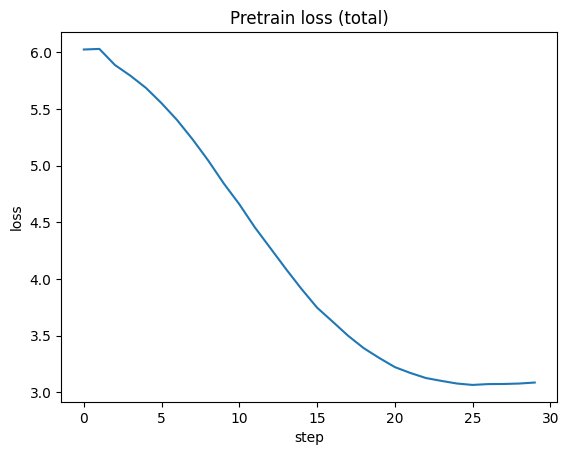

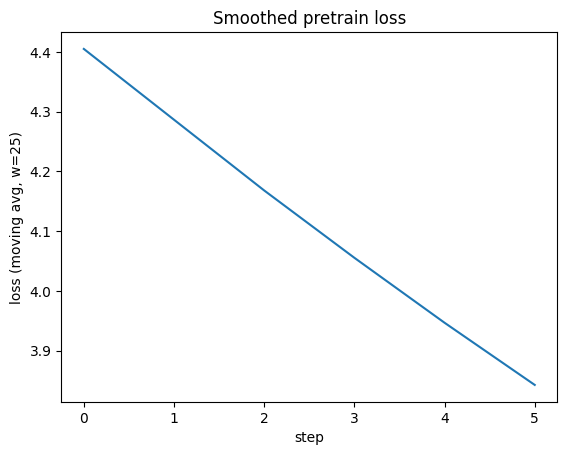

In [48]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.plot(losses)
plt.xlabel("step")
plt.ylabel("loss")
plt.title("Pretrain loss (total)")
plt.show()

# optional: smoothed curve (moving average)
w = 25
if len(losses) >= w:
    smooth = np.convolve(losses, np.ones(w)/w, mode="valid")
    plt.figure()
    plt.plot(smooth)
    plt.xlabel("step")
    plt.ylabel(f"loss (moving avg, w={w})")
    plt.title("Smoothed pretrain loss")
    plt.show()

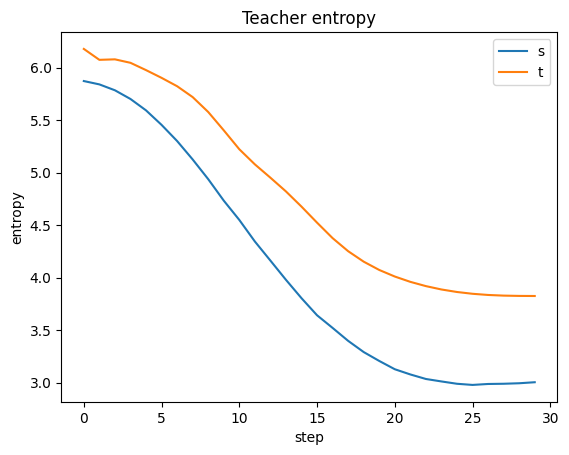

In [50]:
plt.figure()
plt.plot(teacher_entropy)
plt.legend("teacher")
plt.plot(student_entropy)
plt.legend("student")
plt.xlabel("step")
plt.ylabel("entropy")
plt.title("Teacher entropy")
plt.show()


In [ ]:
from tslearn.datasets import UCR_UEA_datasets
from sklearn.metrics import accuracy_score

def resample_to_T(x_np: np.ndarray, T: int) -> np.ndarray:
    """
    Retourne toujours un array (B, C, T).
    Gère:
      - (B, T)
      - (B, T, C)  (tslearn fréquent)
      - (B, C, T)
    """
    if x_np.ndim == 2:
        x = torch.from_numpy(x_np).float().unsqueeze(1)   # (B,1,T)
    elif x_np.ndim == 3:
        # Heuristique: si dernière dim petite => souvent (B,T,C)
        if x_np.shape[2] <= 16 and x_np.shape[1] > x_np.shape[2]:
            x = torch.from_numpy(x_np).float().permute(0, 2, 1)  # (B,C,T)
        else:
            x = torch.from_numpy(x_np).float()  # déjà (B,C,T) probable
    else:
        raise ValueError(f"UCR shape inattendue: {x_np.shape}")

    # interpolate attend (N,C,L) => ici (B,C,T)
    x = F.interpolate(x, size=T, mode="linear", align_corners=False)
    return x.numpy()  # (B,C,T)
@torch.no_grad()

def encode(model: UticaModel, X: torch.Tensor, batch_size=256):
    model.eval()
    feats = []
    dl = torch.utils.data.DataLoader(X, batch_size=batch_size, shuffle=False)
    for xb in dl:
        xb = xb.to(device)
        cls, _ = model(xb)     # <-- DINO-only: 2 outputs
        feats.append(cls.detach().cpu())
    return torch.cat(feats, dim=0)

class LinearProbe(nn.Module):
    def __init__(self, d_in: int, n_classes: int):
        super().__init__()
        self.fc = nn.Linear(d_in, n_classes)

    def forward(self, x): return self.fc(x)

def train_linear_probe(feats_train, y_train, feats_test, y_test, lr=1e-3, epochs=50):
    n_classes = int(y_train.max().item() + 1)
    clf = LinearProbe(feats_train.shape[1], n_classes).to(device)
    opt = torch.optim.AdamW(clf.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    for ep in range(epochs):
        clf.train()
        idx = torch.randperm(feats_train.shape[0])
        xb = feats_train[idx].to(device)
        yb = y_train[idx].to(device)
        logits = clf(xb)
        loss = loss_fn(logits, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()

    clf.eval()
    with torch.no_grad():
        pred = clf(feats_test.to(device)).argmax(dim=-1).cpu().numpy()
    acc = accuracy_score(y_test.numpy(), pred)
    return acc

# Pick one small UCR dataset to validate pipeline
ucr = UCR_UEA_datasets()
name = "ECG200"  # fast sanity dataset
X_train, y_train, X_test, y_test = ucr.load_dataset(name)

# labels to 0..K-1
classes = {c:i for i,c in enumerate(np.unique(y_train))}
y_train = np.array([classes[c] for c in y_train], dtype=np.int64)
y_test  = np.array([classes[c] for c in y_test], dtype=np.int64)

# resample to cfg.T_base -> (B,C,T)
X_train = resample_to_T(X_train, cfg.T_base)
X_test  = resample_to_T(X_test, cfg.T_base)

# torch tensors -> (B,C,T)
X_train_t = torch.from_numpy(X_train).float()
X_test_t  = torch.from_numpy(X_test).float()

print("X_train_t shape:", X_train_t.shape)  
print("X_test_t shape :", X_test_t.shape)

y_train_t = torch.from_numpy(y_train)
y_test_t  = torch.from_numpy(y_test)

# Use teacher as encoder (EMA is typically stronger)
feats_train = encode(teacher, X_train_t, batch_size=256)
feats_test  = encode(teacher, X_test_t, batch_size=256)

acc = train_linear_probe(feats_train, y_train_t, feats_test, y_test_t, lr=1e-3, epochs=50)
print(f"UCR {name} linear-probe acc:", acc)

X_train_t shape: torch.Size([100, 1, 512])
X_test_t shape : torch.Size([100, 1, 512])
UCR ECG200 linear-probe acc: 0.64


In [52]:
!pip -q install umap-learn

In [53]:
Z_train = feats_train.numpy()
Z_test  = feats_test.numpy()

Z = np.vstack([Z_train, Z_test])
y = np.concatenate([y_train, y_test])

split = np.array([0]*len(Z_train) + [1]*len(Z_test))  # 0=train, 1=test

print("Z shape:", Z.shape, "y shape:", y.shape)

from sklearn.preprocessing import StandardScaler
Zs = StandardScaler().fit_transform(Z)

Z shape: (200, 256) y shape: (200,)


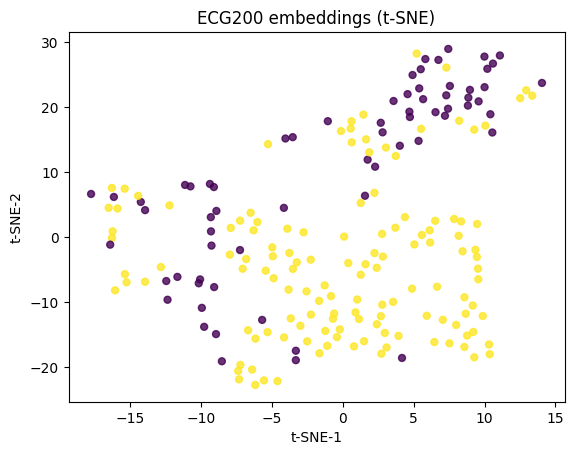

In [54]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=20,     # try 5, 10, 20, 30
    learning_rate="auto",
    init="pca",
    random_state=0
)

Z_2d_tsne = tsne.fit_transform(Zs)

plt.figure()
plt.scatter(Z_2d_tsne[:,0], Z_2d_tsne[:,1], c=y, s=25, alpha=0.8)
plt.title("ECG200 embeddings (t-SNE)")
plt.xlabel("t-SNE-1"); plt.ylabel("t-SNE-2")
plt.show()